<a href="https://colab.research.google.com/github/rharms3/Visualization-Class/blob/master/Assignment_2_1036_RHarms3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# (PSL) Coding Assignment 2

Fall 2022

Richard Harms - RHarms3

# Part I: Implement Lasso

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import glmnet_python
from glmnet import glmnet
from cvglmnet import cvglmnet
from cvglmnetPredict import cvglmnetPredict
from cvglmnetPlot import cvglmnetPlot
from cvglmnetCoef import cvglmnetCoef


# Load Data

In [32]:
myData = pd.read_csv("Coding2_Data.csv")
var_names = myData.columns
y = myData[["Y"]].to_numpy()
X = myData.drop(["Y"], axis = 1).to_numpy()

In [33]:
X.shape, len(y)
myData
df2= myData.describe()
print(df2)
# Y is only column Y
# X is the rest of the table minus the Y column 

               V1          V2          V3          V4          V5          V6  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    -0.780436    1.136364    2.160192    0.069170   -0.610026    1.831864   
std      2.162050    2.332245    0.776987    0.253994    0.201483    0.112325   
min     -5.064036    0.000000   -0.776529    0.000000   -0.954512    1.270041   
25%     -2.500488    0.000000    1.646734    0.000000   -0.800732    1.772492   
50%     -1.360641    0.000000    2.271094    0.000000   -0.619897    1.825919   
75%      1.302119    1.250000    2.895912    0.000000   -0.471605    1.890624   
max      4.488369   10.000000    3.322875    1.000000   -0.138113    2.172476   

               V7          V8          V9         V10         V11         V12  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     5.060790    1.188032    1.867661    5.931405    2.150054    3.566740   
std      3.566546    0.5395

# CD for Lasso

In [34]:
def one_var_lasso(r, z, lam):
    
    #################
    # Your CODE
    #################

    # A = R transpose * z / norm Z squared
    # then plug that back into the formula 2
    #
    a = np.dot(r.transpose(),z) / (np.linalg.norm(z)**2)

    n = r.size
    
    newlam = (2*n*lam )/(np.linalg.norm(z)**2)
    
    if a > (newlam/2):
        b = a - (newlam/2)
    elif abs(a) <= (newlam/2):
        b = 0
    elif a < -(newlam/2):
        b = a  + (newlam/2)
    
    return(b)

In [36]:
def MyLasso(X, y, lam_seq, maxit = 100):
    
    # Input
    # X: n-by-p design matrix without the intercept 
    # y: n-by-1 response vector 
    # lam.seq: sequence of lambda values (arranged from large to small)
    # maxit: number of updates for each lambda 
    
    # Output
    # B: a (p+1)-by-len(lam.seq) coefficient matrix 
    #    with the first row being the intercept sequence 

  
    n, p = X.shape
    nlam = len(lam_seq)
    B = np.zeros((p+1, nlam))
    
    ##############################
    # YOUR CODE: 
    # (1) newX = Standardizad X; 
    # (2) Record the centers and scales used in (1) 
    ##############################

    # loop through each column of X and subtract the mean of the column from each value and store i nnew vector, 
    # also capture each mean for the colum in a centers vector
    
    newX = np.zeros((n, p))
    stdcol = np.zeros((1,p))
    
    xmean = X.mean(axis=0)
    stdcol = X.std(axis=0)
    
    newX = (X - xmean)/stdcol
    
    # Initilize coef vector b and residual vector r
    b = np.zeros(p)
    r = y
    
    # Triple nested loop
    for m in range(nlam):
        for step in range(maxit):
            for j in range(p):
                X_j = newX[:, j].reshape(-1,1)
                r = r + X_j * b[j]
                b[j] = one_var_lasso(r, X_j, lam_seq[m])
                r = r - X_j * b[j]
        B[1:, m] = b 
        
    ##############################
    # YOUR CODE:
    # Scale back the coefficients;
    # Update the intercepts stored in B[1,] - or B[0,] as 0 is first not 1
    ##############################
  
    ymean = y.mean(axis =0)

    B[0,] = ymean - np.dot(np.divide(xmean,stdcol), B[1:,]) # (mcolmean * B[1:p+1,])
 
    return(B)

In [37]:
log_lam_seq = np.linspace(-1, -8, num = 80)
lam_seq = np.exp(log_lam_seq)
myout = MyLasso(X, y, lam_seq, maxit = 100)

(-8.35, -0.6499999999999999, -0.2743276335841055, 0.07194637350257987)

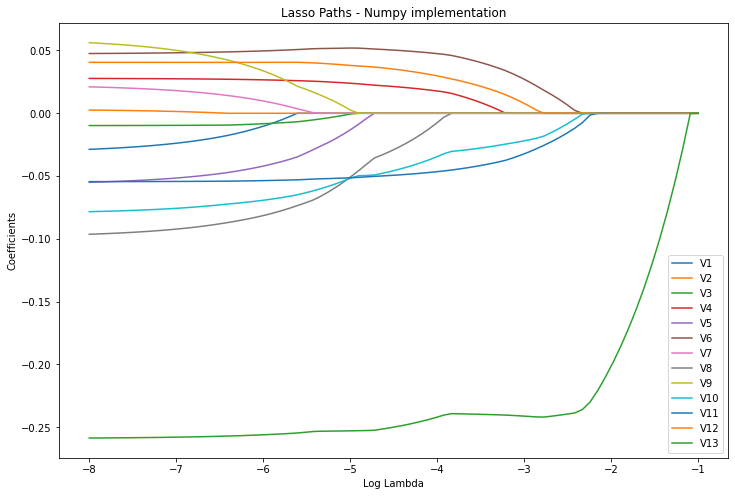

In [38]:
p, _ = myout.shape
plt.figure(figsize = (12,8))

for i in range(p-1):
    plt.plot(log_lam_seq, myout[i+1, :], label = var_names[i])

plt.xlabel('Log Lambda')
plt.ylabel('Coefficients')
plt.title('Lasso Paths - Numpy implementation')
plt.legend()
plt.axis('tight')

# Check the Accuracy

Compare the accuracy of your algorithm against the output from glmnet. The maximum difference between the two coefficient matrices should be less than 0.005.


In [39]:
lasso_coef = pd.read_csv("Coding2_lasso_coefs.csv").to_numpy()
lasso_coef.shape

(14, 80)

In [40]:
abs(myout - lasso_coef).max()

0.4105274512033368

# Simulation Study

# Case I

**Questions:**
1.   The method(s) that performed the best - **Ridge min** and **Lasso min** seemed to perform the best.
2.   The method(s) that performed the worst - **Lasso 1se** seemed to perform the worst
3.   For Ridge regression, **Lambda.min** produced the best MSPE 
4.   For Lasso regression, **Lambda.min** produced the best MSPE
5.   Does L.Refit perform better than Lasso.ise?
  **Answer** - from my results it appears that Refit performed better.
6.   Is Full comparable or not to the best of the others?
 **Answer** - no, full is not comparable to the best of the others.  Its performed worse in the prediction errors.



In [41]:
# Set seed
np.random.seed(1036)

myData = pd.read_csv("Coding2_Data2.csv")
var_names = myData.columns
Y = myData[["Y"]].to_numpy()
X = myData.drop(["Y"], axis = 1).to_numpy()

In [42]:
n = len(Y) #(Y)
indices = np.arange(0, n)
np.random.shuffle(indices)
test_ind = indices[:int(np.floor(0.25*n))]
train_ind = indices[len(test_ind):]

# Full Model



In [43]:
full = LinearRegression().fit(X[train_ind, :], Y[train_ind]) #Y
fullmean = np.mean((full.predict(X[test_ind, :]) - Y[test_ind])**2) #Y
np.mean((full.predict(X[test_ind, :]) - Y[test_ind])**2) #Y

0.027860240867754585

# Ridge Regression

First Determine Lambda sequence

In [44]:
ridge_seq = np.exp(np.linspace(-2, -10, num=100))
ridge_out = cvglmnet(x = X.copy(), y = Y.copy(), alpha = 0, lambdau = ridge_seq)

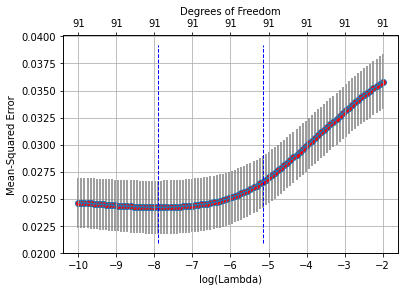

In [45]:
cvglmnetPlot(ridge_out)

In [46]:
ridge = cvglmnet(x = X[train_ind, :].copy(), y = Y[train_ind].copy(), alpha = 0, lambdau = ridge_seq)
pred = cvglmnetPredict(ridge, s = ridge['lambda_min'], newx=X[test_ind, :].copy())
ridgemean = np.mean((Y[test_ind] - pred)**2)
np.mean((Y[test_ind] - pred)**2)

0.02468072530455234

In [47]:
pred = cvglmnetPredict(ridge, s = ridge['lambda_1se'], newx=X[test_ind, :].copy())
ridge1semean = np.mean((Y[test_ind] - pred)**2)
np.mean((Y[test_ind] - pred)**2)

0.03061030721235193

# Lasso

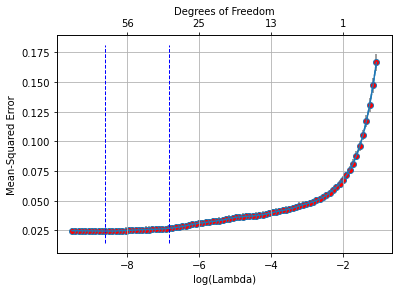

In [48]:
lasso_out = cvglmnet(x = X.copy(), y = Y.copy(), alpha = 1)
cvglmnetPlot(lasso_out)

In [49]:
lasso = cvglmnet(x = X[train_ind, :].copy(), y = Y[train_ind].copy(), alpha = 1)
pred = cvglmnetPredict(lasso, s = lasso['lambda_min'], newx=X[test_ind, :].copy())
lamminmean = np.mean((Y[test_ind] - pred)**2)
np.mean((Y[test_ind] - pred)**2)

0.025602793886378445

In [50]:
pred = cvglmnetPredict(lasso, s = lasso['lambda_1se'], newx=X[test_ind, :].copy())
lam1semean = np.mean((Y[test_ind] - pred)**2)
np.mean((Y[test_ind] - pred)**2)

0.026426829585801285

# Refit

In [52]:
lasso_coef = cvglmnetCoef(lasso, s = 'lambda_1se')
var_sel = np.nonzero(lasso_coef[1:])[0]
tmp_train = X[train_ind[:,None], var_sel[None, :]]
tmp_test = X[test_ind[:,None], var_sel[None, :]]
refit_model = LinearRegression().fit(tmp_train, Y[train_ind])
pred = refit_model.predict(tmp_test)
refitmean = np.mean((pred - Y[test_ind])**2)
np.mean((pred - Y[test_ind])**2)

0.025667296945873032

# PCR

Sample code for PCR (Principle Components Regression) with the number of components chosen by 10-fold cross validation

In [53]:
class PCR(object):

    def __init__(self, num_folds=10):
        self.folds = num_folds

    def fit(self, X, Y):
        n, p = X.shape
        indices = np.arange(n)
        np.random.shuffle(indices)
        index_sets = np.array_split(indices, self.folds)
        ncomp = min(p, n - 1 - max([len(i) for i in index_sets]))
        cv_err = np.zeros(ncomp)
        
        for ifold in range(self.folds):
            train_inds =  np.delete(index_sets, obj=ifold, axis=0).ravel()
            test_inds = index_sets[ifold]
            
            X_train = X[train_inds, :]
            pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA())])
            pipeline.fit(X_train)
            X_train = pipeline.transform(X_train)
            coefs = Y[train_inds].T @ X_train / np.sum(X_train**2, axis=0)
            b0 = np.mean(Y[train_inds])

            X_test = pipeline.transform(X[test_inds, :])
            
            for k in np.arange(ncomp):
                preds = X_test[:, :k] @ coefs.T[:k] + b0
                cv_err[k] += cv_err[k] + np.sum((Y[test_inds]-preds)**2)

        min_ind = np.argmin(cv_err)
        self.ncomp = min_ind+1
        pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=self.ncomp))])
        self.transform = pipeline.fit(X)
        self.model = LinearRegression().fit(self.transform.transform(X), Y)

    def predict(self, X):
        X_ = self.transform.transform(X)
        return self.model.predict(X_)

In [54]:
pcr = PCR()
pcr.fit(X[train_ind, :], Y[train_ind])
preds = pcr.predict(X[test_ind, :])
pcrmean = np.mean((Y[test_ind] - preds)**2)
np.mean((Y[test_ind] - preds)**2)

0.027860240867757746

In [55]:
pcr.ncomp

91

# Case I Simulation code - 50 times

In [63]:
fullmean1 = []
ridgemean1 = []
ridge1semean1 = []
lassominmean1 = []
lasso1semean1 = []
refitmean1 = []
pcrmean1 = []
n = len(Y) #(Y)
indices = np.arange(0, n)

for sym in range(50):
  np.random.shuffle(indices)
  test_ind = indices[:int(np.floor(0.25*n))]
  train_ind = indices[len(test_ind):]

  # Full
  full = LinearRegression().fit(X[train_ind, :], Y[train_ind]) #Y
  fullmean1.append(np.mean((full.predict(X[test_ind, :]) - Y[test_ind])**2))

  # Ridge min and 1se
  ridge = cvglmnet(x = X[train_ind, :].copy(), y = Y[train_ind].copy(), alpha = 0, lambdau = ridge_seq)
  
  pred = cvglmnetPredict(ridge, s = ridge['lambda_min'], newx=X[test_ind, :].copy())
  ridgemean1.append(np.mean((Y[test_ind] - pred)**2))

  pred = cvglmnetPredict(ridge, s = ridge['lambda_1se'], newx=X[test_ind, :].copy())
  ridge1semean1.append(np.mean((Y[test_ind] - pred)**2))

  # Lasso mon and 1se
  lasso = cvglmnet(x = X[train_ind, :].copy(), y = Y[train_ind].copy(), alpha = 1)
  
  pred = cvglmnetPredict(lasso, s = lasso['lambda_min'], newx=X[test_ind, :].copy())
  lassominmean1.append(np.mean((Y[test_ind] - pred)**2))

  pred = cvglmnetPredict(lasso, s = lasso['lambda_1se'], newx=X[test_ind, :].copy())
  lasso1semean1.append(np.mean((Y[test_ind] - pred)**2))

  # Refit
  lasso_coef = cvglmnetCoef(lasso, s = 'lambda_1se')
  var_sel = np.nonzero(lasso_coef[1:])[0]
  tmp_train = X[train_ind[:,None], var_sel[None, :]]
  tmp_test = X[test_ind[:,None], var_sel[None, :]]
  refit_model = LinearRegression().fit(tmp_train, Y[train_ind])
  pred = refit_model.predict(tmp_test)
  refitmean1.append(np.mean((pred - Y[test_ind])**2))

  # PCR
  pcr = PCR()
  pcr.fit(X[train_ind, :], Y[train_ind])
  preds = pcr.predict(X[test_ind, :])
  pcrmean1.append(np.mean((Y[test_ind] - preds)**2))

# Case I - Graph the results of the MSPE values for each model

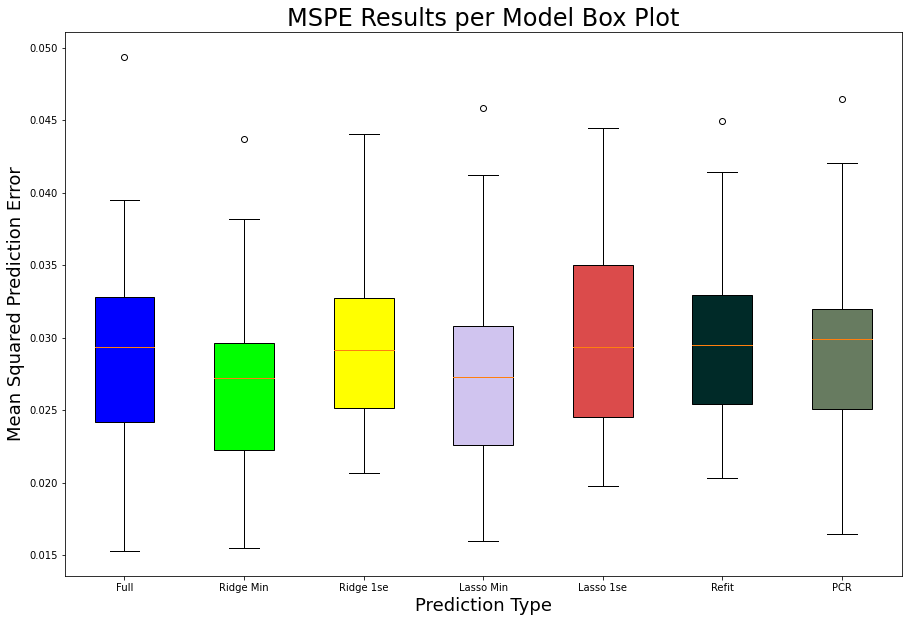

In [64]:
# Graph the results
data = [fullmean1, ridgemean1, ridge1semean1, lassominmean1, lasso1semean1, refitmean1, pcrmean1 ]  # these are the collected sets of data from the fit models

fig = plt.figure(figsize =(15, 10))
plt.title("MSPE Results per Model Box Plot", fontsize = 24)

# x-axis labels
plt.xlabel('Prediction Type', fontsize = 18)
plt.ylabel('Mean Squared Prediction Error', fontsize = 18)
names = ['Full','Ridge Min', 'Ridge 1se', 'Lasso Min', 'Lasso 1se', 'Refit', 'PCR']

# Set Colors for each box
colors = ['#0000FF', '#00FF00', '#FFFF00','#d0c4ef', '#db4b4b', '#002a28','#677b60']

# Creating plot
cplot = plt.boxplot(data, labels = names, patch_artist = True)
for patch, color in zip(cplot['boxes'], colors):
    patch.set_facecolor(color)
    
# show plot
plt.show()

# Case II

Questions:
1.   The method(s) that performed the best - **Lasso Min** seems to be the best
2.   The method(s) that performed the worst - **PCR** seems to be the worst
3.   Do any method(s) perform better in one case but not in the other? Why?
  
  **Answer** -  Yes - overall case I performs better than Case II.  However in comparing each prediciton type comparatively **Ridge Min** does not perform as well in Case II vs how it compared in Case I.  Same for **PCR** and **Refit**.  I think this may have to do with the additional 500 features of "noise" that are included in the data3 file.  This noise applies a penalty in the calculations and the the worse outcomes.
4.  With Data3 containing all data2 featuers plus additional, one may expect the best MSPE case is smaller than best MSPE in case I, does the simulation support this ?
  
  **Answer** - no, the simulation does not show this.  It actually shows worse MSPE values for each of the prediction models in Case II.  I feel this is due to the additional noise data contained in the 500 additinoal colunms provided in the data3 file. This noise applies a penalty in the calculations and the the worse outcomes.





In [72]:
myData2 = pd.read_csv("Coding2_Data3.csv")
var_names2 = myData2.columns
Y2 = myData2[["Y"]].to_numpy()
X2 = myData2.drop(["Y"], axis = 1).to_numpy()

# Case II Simulation code - 50 times

Without Full model calculated

In [73]:
ridgemean2 = []
ridge1semean2 = []
lassominmean2 = []
lasso1semean2 = []
refitmean2 = []
pcrmean2 = []
n2 = len(Y2) #(Y)
indices2 = np.arange(0, n2)

for sym in range(50): 
  np.random.shuffle(indices2)
  test_ind2 = indices2[:int(np.floor(0.25*n2))]
  train_ind2 = indices2[len(test_ind2):]

  # Ridge min and 1se
  ridge = cvglmnet(x = X2[train_ind2, :].copy(), y = Y2[train_ind2].copy(), alpha = 0, lambdau = ridge_seq)
  
  pred = cvglmnetPredict(ridge, s = ridge['lambda_min'], newx=X2[test_ind2, :].copy())
  ridgemean2.append(np.mean((Y2[test_ind2] - pred)**2))

  pred = cvglmnetPredict(ridge, s = ridge['lambda_1se'], newx=X2[test_ind2, :].copy())
  ridge1semean2.append(np.mean((Y2[test_ind2] - pred)**2))

  # Lasso mon and 1se
  lasso = cvglmnet(x = X2[train_ind2, :].copy(), y = Y2[train_ind2].copy(), alpha = 1)
  
  pred = cvglmnetPredict(lasso, s = lasso['lambda_min'], newx=X2[test_ind2, :].copy())
  lassominmean2.append(np.mean((Y2[test_ind2] - pred)**2))

  pred = cvglmnetPredict(lasso, s = lasso['lambda_1se'], newx=X2[test_ind2, :].copy())
  lasso1semean2.append(np.mean((Y2[test_ind2] - pred)**2))

  # Refit
  lasso_coef = cvglmnetCoef(lasso, s = 'lambda_1se')
  var_sel = np.nonzero(lasso_coef[1:])[0]
  tmp_train = X2[train_ind2[:,None], var_sel[None, :]]
  tmp_test = X2[test_ind2[:,None], var_sel[None, :]]
  refit_model = LinearRegression().fit(tmp_train, Y2[train_ind2])
  pred = refit_model.predict(tmp_test)
  refitmean2.append(np.mean((pred - Y2[test_ind2])**2))

  # PCR
  pcr = PCR()
  pcr.fit(X2[train_ind2, :], Y2[train_ind2])
  preds = pcr.predict(X2[test_ind2, :])
  pcrmean2.append(np.mean((Y2[test_ind2] - preds)**2))

# Case II - Graph the results of the MSPE values for each model

Without Full Model

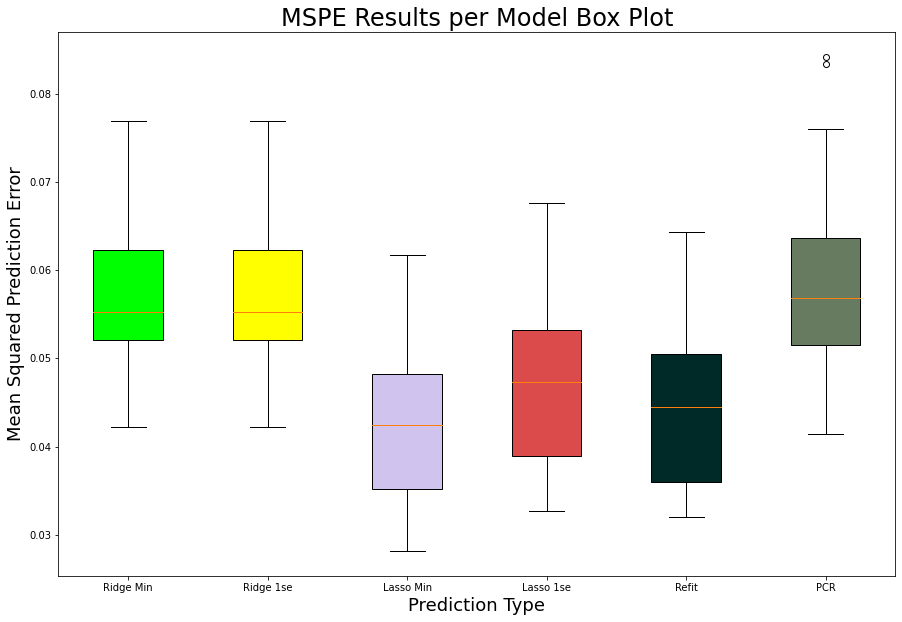

In [74]:
# Graph the results
data = [ridgemean2, ridge1semean2, lassominmean2, lasso1semean2, refitmean2, pcrmean2 ]  # these are the collected sets of data from the fit models

fig = plt.figure(figsize =(15, 10))
plt.title("MSPE Results per Model Box Plot", fontsize = 24)

# x-axis labels
plt.xlabel('Prediction Type', fontsize = 18)
plt.ylabel('Mean Squared Prediction Error', fontsize = 18)
names = ['Ridge Min', 'Ridge 1se', 'Lasso Min', 'Lasso 1se', 'Refit', 'PCR']

# Set Colors for each box
colors = ['#00FF00', '#FFFF00','#d0c4ef', '#db4b4b', '#002a28','#677b60']

# Creating plot
cplot = plt.boxplot(data, labels = names, patch_artist = True)
for patch, color in zip(cplot['boxes'], colors):
    patch.set_facecolor(color)
    
# show plot
plt.show()

# Comparison Box Plot Case I vs Case II (excluding full)

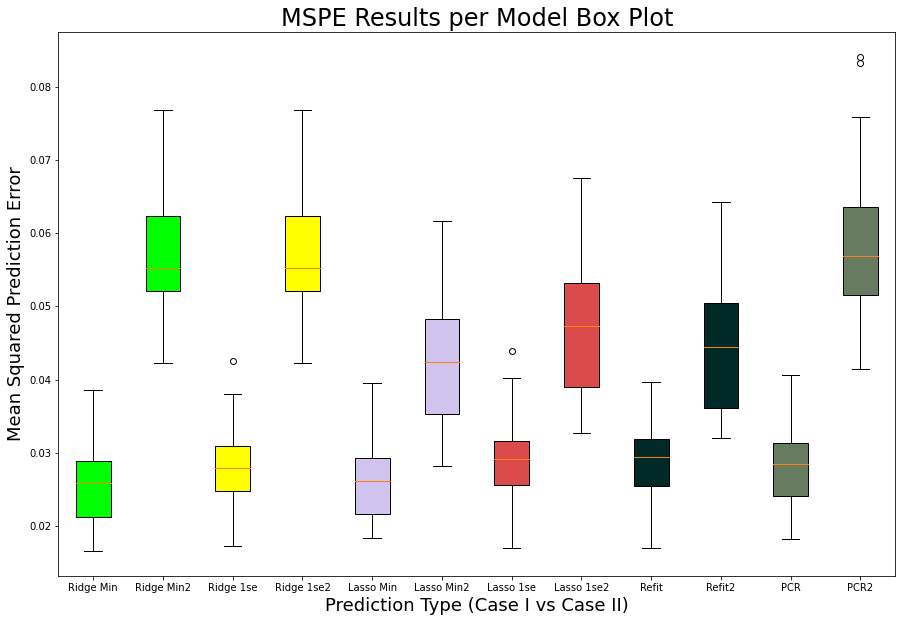

In [77]:
# Graph the results - Comparisons
data = [ridgemean, ridgemean2, ridge1semean, ridge1semean2, lassominmean, lassominmean2, lasso1semean, lasso1semean2, refitmean, refitmean2, pcrmean,pcrmean2 ]  # these are the collected sets of data from the fit models

fig = plt.figure(figsize =(15, 10))
plt.title("MSPE Results per Model Box Plot", fontsize = 24)

# x-axis labels
plt.xlabel('Prediction Type (Case I vs Case II)', fontsize = 18)
plt.ylabel('Mean Squared Prediction Error', fontsize = 18)
names = ['Ridge Min','Ridge Min2', 'Ridge 1se', 'Ridge 1se2','Lasso Min', 'Lasso Min2','Lasso 1se', 'Lasso 1se2','Refit', 'Refit2','PCR','PCR2']

# Set Colors for each box
colors = ['#00FF00','#00FF00', '#FFFF00','#FFFF00','#d0c4ef', '#d0c4ef','#db4b4b', '#db4b4b','#002a28','#002a28','#677b60','#677b60']

# Creating plot
cplot = plt.boxplot(data, labels = names, patch_artist = True)
for patch, color in zip(cplot['boxes'], colors):
    patch.set_facecolor(color)
    
# show plot
plt.show()

# Pip Install command for glmnet_python to work

In [1]:
 pip install  --force-reinstall --no-deps git+https://gitlab.com/joseph-r-hamilton_/public/glmnet_python.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://gitlab.com/joseph-r-hamilton_/public/glmnet_python.git to /tmp/pip-req-build-c96g4m8v
  Running command git clone -q https://gitlab.com/joseph-r-hamilton_/public/glmnet_python.git /tmp/pip-req-build-c96g4m8v
  Created wheel for glmnet-python: filename=glmnet_python-0.2.0-py3-none-any.whl size=184566 sha256=3218ea2e1df001d6e568c9d66ec5136c5a8bc05dfdd8a6d8c8fd816f72d60dd6
  Stored in directory: /tmp/pip-ephem-wheel-cache-1dcenkji/wheels/9d/54/fa/18d9248ed88f4c31a0cbd4f329fb69d509aba2ab3d3575385a
Successfully built glmnet-python
